In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

# Load test dataset

In [1]:
import tensorflow_datasets as tsdf

imdb, info = tsdf.load("imdb_reviews", as_supervised=True, with_info=True)

In [2]:
imdb

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [3]:
train, test = imdb['train'], imdb['test']

## NOTE

You can shuffle, implement padding and split into batches `tf.data.Dataset` by following code:
```
train = train.shuffle(BUFFER_SIZE)
train = train.padded_batch(BATCH_SIZE, train.output_shapes)
```

In [4]:
single_example = next(iter(train))[0]
single_example

<tf.Tensor: shape=(), dtype=string, numpy=b'This is a big step down after the surprisingly enjoyable original. This sequel isn\'t nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is toned down in this entry. The performances are all adequate, but this time the script lets us down. The action is merely routine and the plot is only mildly interesting, so I need lots of silly laughs in order to stay entertained during a "Trancers" movie. Unfortunately, the laughs are few and far between, and so, this film is watchable at best.'>

In [7]:
# if you iterate of dataset, you can receive training example and label
for s,l in train:
    print(type(s))
    # tensor > bytes
    print(type(s.numpy()))
    print(l)
    break

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'bytes'>
tf.Tensor(0, shape=(), dtype=int64)


## Transforming train set from tf.data.Dataset to list

In [5]:
train_sentences = []
train_labels = []

for s,l in train:
    train_sentences.append(str(s.numpy()))
    train_labels.append(l.numpy())

In [9]:
test_sentences = []
test_labels = []

for s,l in test:
    test_sentences.append(str(s.numpy()))
    test_labels.append(l.numpy())

In [6]:
train_labels[0:10]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

In [11]:
train_labels[0:10]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

## Tokenizing sentences

In [12]:
vocab_size = 10000
oov_tok = 'OOV'
max_length = 128
pad_type = 'post'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

t = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
t.fit_on_texts(train_sentences)
word_index = t.word_index
train_seq = t.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seq, maxlen=max_length, truncating=pad_type, padding=pad_type)

test_seq = t.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seq, maxlen=max_length, truncating=pad_type, padding=pad_type)

In [13]:
test_padded[0:2]

array([[2101, 2049,   17,  131, 4572, 2117,  195, 1634, 1570,  145,  843,
          31,   11,   99,  105,   32,   12,  210,   14,    1,    3, 1401,
          44,  471,   29,    4,    1,   22,  146,   13,  304,   75,  997,
          16, 1308,    2,   18,   95,  287,   50,    1,    1,   17,    1,
           1,   21, 2585,   11,  247,  208,  196,   26,  553, 2815,  654,
         127,  235,   11,  216,  713,    3,    2, 5147,   38,   55,   11,
         258,   46,   27,   14,   15, 1689,   11,  196,    2,   18,   14,
         168,    6,   29, 4572,   10,   14,   10,   14,   54, 4572,    3,
        1977,  477,    6,   29,  438,   98,   32,  175,  480,  332,   46,
         175, 5254,  155, 2074,   98,   34, 1560,   22,   13,  246, 2544,
          58,   67,   29,    9,    2, 2630, 1435,   10,   21,    4,    1,
           1,   15,   77,   15,   11,  196,   10],
       [  59,   11,  386,  323,   12,   32,   63,  723, 2673,    3, 1667,
          10,   57, 1217,   11,   14, 2027,   11,  432,  101,

In [14]:
test_padded.shape

(25000, 128)

# Embedding (as part of model)

In [15]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Result of `Embedding()` layer is 2D (we're ignoring batch size), with dimensions (length_of_input, embedding_dim)
### So in order to feed them into `Dense()` layer, you need to `Flatten()` them into 1D (we're ignoring batch size), like `.reshape(-1, 1)` for numpy arrays
### This will result into dimension of `length_of_input * embedding_dim`, in case above `128 * 16 = 2048`, which you can see below..

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 172,301
Trainable params: 172,301
Non-trainable params: 0
_________________________________________________________________


### `GlobalAveragePooling1D()` averages across vector (don't know what this means), but results into lower dimensionality layer and is little faster. Can be used as well! 

### Accuracy after 10 epochs is worse though (see below)

In [17]:
embedding_dim = 16

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [18]:
import numpy as np
h = model.fit(train_padded, np.array(train_labels), epochs=10, batch_size=500,\
                validation_data=(test_padded, np.array(test_labels)))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 1s 45us/sample - loss: 0.6869 - accuracy: 0.5579 - val_loss: 0.6662 - val_accuracy: 0.6516
Epoch 2/10
25000/25000 [==============================] - 1s 30us/sample - loss: 0.5390 - accuracy: 0.7762 - val_loss: 0.4505 - val_accuracy: 0.8011
Epoch 3/10
25000/25000 [==============================] - 1s 34us/sample - loss: 0.3347 - accuracy: 0.8669 - val_loss: 0.3820 - val_accuracy: 0.8307
Epoch 4/10
25000/25000 [==============================] - 1s 31us/sample - loss: 0.2461 - accuracy: 0.9113 - val_loss: 0.3751 - val_accuracy: 0.8322
Epoch 5/10
25000/25000 [==============================] - 1s 29us/sample - loss: 0.1863 - accuracy: 0.9400 - val_loss: 0.3841 - val_accuracy: 0.8294
Epoch 6/10
25000/25000 [==============================] - 1s 30us/sample - loss: 0.1377 - accuracy: 0.9626 - val_loss: 0.4009 - val_accuracy: 0.8259
Epoch 7/10
25000/25000 [==============================] 

In [19]:
h2 = model2.fit(train_padded, np.array(train_labels), epochs=10, batch_size=500,\
                validation_data=(test_padded, np.array(test_labels)))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 1s 47us/sample - loss: 0.6887 - accuracy: 0.6202 - val_loss: 0.6824 - val_accuracy: 0.6874
Epoch 2/10
25000/25000 [==============================] - 1s 29us/sample - loss: 0.6696 - accuracy: 0.7175 - val_loss: 0.6583 - val_accuracy: 0.7122
Epoch 3/10
25000/25000 [==============================] - 1s 29us/sample - loss: 0.6344 - accuracy: 0.7478 - val_loss: 0.6197 - val_accuracy: 0.7444
Epoch 4/10
25000/25000 [==============================] - 1s 28us/sample - loss: 0.5846 - accuracy: 0.7813 - val_loss: 0.5723 - val_accuracy: 0.7690
Epoch 5/10
25000/25000 [==============================] - 1s 29us/sample - loss: 0.5287 - accuracy: 0.8090 - val_loss: 0.5248 - val_accuracy: 0.7939
Epoch 6/10
25000/25000 [==============================] - 1s 27us/sample - loss: 0.4756 - accuracy: 0.8292 - val_loss: 0.4836 - val_accuracy: 0.8054
Epoch 7/10
25000/25000 [==============================] 

# Getting and Visualizing Embeddings

In [20]:
e = model.layers[0]
weights = e.get_weights()[0]

In [21]:
print(e)
print(type(weights))
print(weights.shape)

<class 'numpy.ndarray'>
(10000, 16)


### Shape of Embedding() layer weights is (vocab_size, embedding_dim)

In [22]:
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

In [23]:
reverse_word_index[1]

'OOV'

In [24]:
import io

out_m = io.open('B_a_embedding_layer_meta.tsv', 'w', encoding='utf-8')
out_v = io.open('B_a_embedding_layer_vectors.tsv', 'w', encoding='utf-8')

for word_nr in range(1, vocab_size):
    
    word = reverse_word_index[word_nr]
    out_m.write(word+'\n')

    # takes embedding vector for specific word (length == embedding_dim)
    # converts every value of it into string 
    # places tab in between of them and finalizes with new line (to form a line)
    embeddings = weights[word_nr]
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_m.close()
out_v.close()


## Now you can load these files into http://projector.tensorflow.org/ in order to visualize your embeddings!

### Try "Sphereize data"

# Use pretrained Embeddings

You may want to use already create Embeddings (espacially in case of NLP), and there's a way to give Embedding() layer weight, as well as do not train them.  

For that use following code:  
```
    tf.keras.layers.Embedding(vocab_size+, embedding_dim, input_length=max_length,
                              weights=embeddings_matrix], trainable=False)
```

# Plot curves

In [34]:
import matplotlib.pyplot as plt

def plot_curves(history, string):
     plt.plot(history.history[string])
     plt.plot(history.history['val_' + string])
     plt.xlabel("Epochs")
     plt.ylabel(string)
     plt.legend([string, 'val_' + string])
     plt.show()

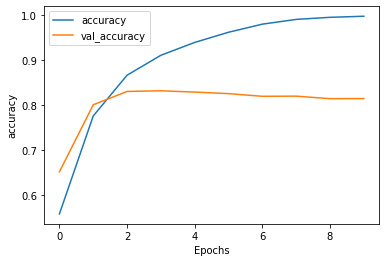

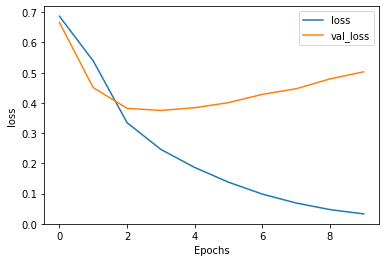

In [35]:
plot_curves(h, 'accuracy')
# learning curve using 'loss'
plot_curves(h, 'loss')

In [37]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])